# 1. Prepare the collected data for analysis

The experiment folder must be put in the *Past_experiments* folder, otherwise this script needs to be adapted. The collected data from PsyToolkit needs to be put in a folder called *collected_data* within the experiment folder. A new folder called *computed_data* is created by this script in the given experiment folder. See the **Final_experiment** folder as example.

This section of this notebook creates two new files in *computed_data*;
* experiment_training_responses.csv
* experiment_responses.csv

The first file contains the answers to the first half of the experiment, where participants are trained on the task. The second contains the (hopefully) more accurate responses which are used to evaluate reaction times.

In [5]:
from nltk.corpus import wordnet as wn
import pandas as pd
import numpy as np
import os, csv, json

# ------------------------------------------------------- #
# SET THE FOLDER NAME OF YOUR EXPERIMENT HERE!            #
EXPERIMENT_DIRECTORY = "E1"
# ------------------------------------------------------- #
# SET THE TAXONOMY BRANCHES USED IN YOUR EXPERIMENT HERE! #
BRANCHES = ['edible_fruit.n.01', 'clothing.n.01', 'hand_tool.n.01', 'musical_instrument.n.01', 'furniture.n.01']
# ------------------------------------------------------- #



# Setting the current working directory
cwd = os.path.abspath("../Past_experiments/")
cwd = os.path.join(cwd, EXPERIMENT_DIRECTORY)

# Setting the collection folder path and computed data folder path. 
# Creates the computed data folder if this has not been done yet.
collected_data_folder = os.path.join(cwd, 'collected_data')
computed_data_folder = os.path.join(cwd, 'computed_data')
if not os.path.exists(computed_data_folder):
    os.mkdir(computed_data_folder)

#==============================================#
# Below here are the function definitions.     #
# Go to the next code cell to create the data. #
#==============================================#

def get_branch(cat):
    """
    This function takes the the category name used in the experiment (where no dots or minuses could be contained)
    and returns the taxonomy branch it was originally chosen from.
    input:  (STRING) Wordnet synset name.
    output: (STRING) According branch name. 
    """

    # The wordnet synsets uses dots within the synset names, this was incompatible with our approach, so they had been replaced with underscores.
    # Here we re-replace them to make it compatible with wordnet once again.
    category = cat[::-1].replace('_','.',2)[::-1]

    # Here are 3 PROBLEM CASES, the symbols had to be removed for Psytoolkit,
    # but there is no effective way to find the categories back within Wordnet.
    # That is why they are set manually now, until a better solution is found.
    if category == "highhat_cymbal.n.01":
        category = "high-hat_cymbal.n.01"

    if category == "carpenters_square.n.01":
        category = "carpenter's_square.n.01"

    if category == "carpenters_hammer.n.01":
        category = "carpenter's_hammer.n.01"

    # Fetching the wordnet synset and its hypernyms, see if one of the hypers is one of our branches.
    syn = wn.synset(category)
    hypers = list(set([s.name() for s in syn.closure(lambda s:s.hypernyms())]))
    has_hyper = list(set(hypers) & set(BRANCHES))

    branch = None
    # For when we have a data point where the tested category IS the top level branch
    if syn.name() in BRANCHES:
        branch = syn.name()
    # For all other cases
    elif len(has_hyper)>0:
        branch = has_hyper[0]
    # This should never happen. If it does, you might need to add a replacement name above to the problem cases.
    else:
        print("There must have been a mistake, check your data, there might be missing symbols in a category name.")
        
    return branch

def get_all_responses(file_path, has_train = True):
    """
    This function retrieves all the experiment results that are partitioned by participant as text files at the time of retrieval from Psytoolkit. For our purposes, it is best to have it all in one big data set. Furthermore, a data set detailing participant information is created alongside.
    input:  (STRING) Experiment file path.
            (Logical)Set to false if the experiment did not have a training round
    output: (Pandas dataframe) 2 dataframes, for reaction times per stimuli and for participant information.
    """
    # List all files containing reaction times.
    exp_result_files = os.listdir(os.path.join(file_path,'experiment_data'))
    timing_data = pd.read_csv(os.path.join(file_path,'data_times.csv'))
    other_data = pd.read_csv(os.path.join(file_path,'data.csv'),index_col=False)
    sensible_info = pd.read_csv(os.path.join(file_path,'part_sensible_info.csv'))
    # preparing output variables
    experiment_results = []
    train_results = []
    participant_info = False
    partic_dict = {'partic_id':[],
                        'accuracy':[],
                        'total_time':[],
                        'active_train_time':[],
                        'active_exp_time':[],
                        'eng_native':[],
                        'eng_born':[],
                        'sex':[],
                        'age':[]}

    # Main loop that goes through each file and collects the necessary data
    p_id = 0
    for txt_file in exp_result_files:
        # Saving the participant ID from Prolific
        participant_id = txt_file.split('.')[3]
        # Replacing the participant id with a simple integer.
        p_id += 1
        # create full path to file
        fpath = os.path.join(file_path,'experiment_data',txt_file)
        
        # opening the results file
        with open(fpath, 'r') as file:
            # Reading file into list, record the file length, and calculate the length of one experiment.
            f = file.readlines()
            f_len = len(f)
            exp_len = int(f_len/2)
            # Set local dictionary variable for collected data and a counter for the index.
            data_dict = False
            pos = 0
            # Go through file contents, line by line
            for line in f:
                line = line.strip("\n").split(' ')
                # We record all lines, the first half is the training, the following are the wanted reaction times.
                # The last value that is added to the data frame 'final' tells us if the data point is from the second round.
                # c_name is the category name, c_img is the image that was used in the stimulus. Level and branch are self-explanatory. The stimulus type is either false or true. p_id is the participant ID. 'accurate' tells us if the participant answered correctly. Reaction time is self-explanatory.

                fin = 0
                if has_train:
                    fin = int(line[7])
                else:
                    fin = 1
                    
                if not data_dict:
                    data_dict={'index':[pos], 
                                'group_index':[int(line[0])],
                                'final':[fin],
                                'c_name':[line[1]], 
                                'img':[line[3]],
                                'lvl':[line[2]],
                                'branch':[get_branch(line[1])],
                                'stim_type':[line[4]],
                                'p_id':[p_id], 
                                'accurate':[abs(int(line[5])-2)], 
                                'react_time':[int(line[6])]}
                else:
                    data_dict['index'].append(pos)
                    data_dict['group_index'].append(int(line[0]))
                    data_dict['final'].append(fin)
                    data_dict['c_name'].append(line[1])
                    data_dict['img'].append(line[3])
                    data_dict['lvl'].append(line[2])
                    data_dict['branch'].append(get_branch(line[1]))
                    data_dict['stim_type'].append(line[4])
                    data_dict['p_id'].append(p_id)
                    data_dict['accurate'].append(abs(int(line[5])-2))
                    data_dict['react_time'].append(int(line[6]))
                pos+=1
                pos=int(pos%exp_len)
            # Turn the dictionary into a pandas data frame
            exp_df = pd.DataFrame(data_dict)

            # Finally we collect some meta information about the participant
            # Apart from calculating their accuracy and active working times, 
            # we open participant specific files to add the times they spend on the entire experiment,
            # their language nativity and where they are born. 
            p_data = False
            p_ref = f"s.{participant_id}.txt"
            p_f = os.path.join(file_path,'survey_data',p_ref)
            with open(p_f, 'r') as p_file:
                p_data = p_file.readlines()
            # From the participant file in survey_data, get answers to survey questions. HAVE TO CUT THE 'a:' STILL
            eng_nat = abs(int(p_data[26].split(": ")[1])-2)
            eng_brn = abs(int(p_data[21].split(": ")[1])-2)

            # Get column with answer accuracies (1 or 0) and calculate mean accuracy in second (final) round.
            accuracies =  exp_df.tail(exp_len)['accurate']
            acc = round(accuracies.sum()/exp_len, ndigits=4)
            # Get current participant row in timing sheet and find total time spend on survey.
            p_timings = timing_data.loc[timing_data['participant'] == f"s.{participant_id}.txt"]
            tt = p_timings['TIME_total'].tolist()[0]
            # Calculate total time based on reaction times, for now the static times inbetween rating are missing.
            traint = round(exp_df.loc[exp_df['final']==0]['react_time'].sum()/60000,2)
            expt = round(exp_df.loc[exp_df['final']==1]['react_time'].sum()/60000,2)
            
            prolific_id = other_data.loc[other_data["participant"] == p_ref]["PROLIFIC_PID"].tolist()[0]
            sens = sensible_info.loc[sensible_info["Participant id"]==prolific_id]
            sx = sens['Sex'].tolist()[0]
            age = sens["Age"].tolist()[0]

            partic_dict['partic_id'].append(p_id)
            partic_dict['accuracy'].append(acc)
            partic_dict['total_time'].append(tt)
            partic_dict['active_train_time'].append(traint)
            partic_dict['active_exp_time'].append(expt)
            partic_dict['eng_native'].append(eng_nat)
            partic_dict['eng_born'].append(eng_brn)
            partic_dict['sex'].append(sx)
            partic_dict['age'].append(age)

            experiment_results.append(exp_df)
        participant_info = pd.DataFrame(partic_dict)
    return pd.concat(experiment_results), participant_info


In [9]:
# Computing the results.
all_results, participant_info = get_all_responses(collected_data_folder, False)
print(all_results.head(3))
# Storing the data in CSV files. First declaring the names.
all_results_file = os.path.join(computed_data_folder, "data_all_ans.csv")
participants_file = os.path.join(computed_data_folder, "data_all_participants.csv")

all_results.to_csv(all_results_file, index=False)
participant_info.to_csv(participants_file, index=False)

C:\Users\ht409\AppData\Roaming\Python\Python310\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('physical_entity.n.01') at depth 11
  for synset in acyclic_breadth_first(self, rel, depth):
C:\Users\ht409\AppData\Roaming\Python\Python310\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('physical_entity.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
C:\Users\ht409\AppData\Roaming\Python\Python310\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('physical_entity.n.01') at depth 9
  for synset in acyclic_breadth_first(self, rel, depth):
C:\Users\ht409\AppData\Roaming\Python\Python310\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('physical_entity.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
C:\Users\ht409\AppData\Roaming\Python\

   index  group_index  final             c_name              img       lvl  \
0      0           10      1         bench_n_01       bongo_n_01        bl   
1      1           20      1    clementine_n_02  clementine_n_02   hyponym   
2      2           14      1  edible_fruit_n_01    nailfile_n_01  hypernym   

              branch stim_type  p_id  accurate  react_time  
0     furniture.n.01     False     1         1        1169  
1  edible_fruit.n.01      True     1         1         883  
2  edible_fruit.n.01     False     1         1         646  


# 2. Inspect the computed data before creating annotations

This step is done entirely in the R notebook "experiment_evaluation_notebook.Rmd". It uses the data created in the step above. Participants are evaluated in terms of work quality and stimuli are evaluated in terms of accuracy. Finally reaction times are evaluated to show the significance of basic level effects.

# 3. Basic Levelness Annotation Creation for a Crowd Sourced Gold Standard

First, A data set of the categories used in the experiment is created. It has the original annotator agreements on basic-levelness (3 of 3 agree = True, 2 of 3 agree = False). The original label for basic_levelness is binary. A new value for basic levelness is added, ranging from 0-1. It acts as a ratio of the sample population's display of basic level effects (BLEs), meaning, within a WordNet path, the amount of people that experienced the BLE for a specific category in the path versus those that did not.

Second, All the reaction times of participants are entered in the same data frame. Each participant adds two values per synset; reaction time and accuracy. The population means are noted, along-side the sample standard deviation from the mean. Third, The synsets are rated by using a depth-first, recursive algorithm exploring the WordNet network. Starting from a superordinate (of which there are 5), we follow down the paths, passing a potential basic level, onto a subordinate, where reaction times are compared.

In [1]:
from nltk.corpus import wordnet as wn
import pandas as pd
import os, csv

# specify experiment results folder in question
experiment_data_folder = os.path.abspath("../Past_experiments/E1/collected_data/experiment_data")

# specify experiment 'project file'
experiment_project = pd.read_csv(os.path.abspath("../Past_experiments/E1/Rosch7_E1/Thesis_Experiment.csv"))

# all superordinate categories
branches = experiment_project["hypernym"].unique()

experiment_project.head()


,hypernym,bl,bl_name,bl_certainty,hyponym,hypernym_def,bl_def,hyponym_def,hyponym_img,cont_flag
0,hand_tool.n.01,awl.n.01,awl,True,bradawl.n.01,missing,a pointed tool for marking surfaces or for pun...,an awl for making small holes for brads or sma...,bradawl.n.01.png,True
1,hand_tool.n.01,file.n.04,file,True,nailfile.n.01,missing,a steel hand tool with small sharp teeth on so...,a small flat file for shaping the nails,nailfile.n.01.png,False
2,hand_tool.n.01,hammer.n.02,hammer,True,carpenter's_hammer.n.01,missing,a hand tool with a heavy rigid head and a hand...,a hammer with a cleft at one end for pulling n...,carpenter's_hammer.n.01.png,False
3,hand_tool.n.01,can_opener.n.01,can_opener,True,church_key.n.01,missing,a device for cutting cans open,can opener that has a triangular pointed end t...,church_key.n.01.png,False
4,hand_tool.n.01,plane.n.05,plane,True,smooth_plane.n.01,missing,a carpenter's hand tool with an adjustable bla...,a small plane for finish work,smooth_plane.n.01.png,False


In [3]:
def get_depth_wn(syns):
    # to do
    return 1

This script below creates a clean data frame holding each category only once.
We cannot reuse the experiment project file because it holds triples, not single categories per row. neither can we reuse the experiment results directly because the names are not formatted for wordnet and each category occurs of course multiple times.

In [2]:
#Lists that hold column information for final data frame
brs = []
syns = []
gloss = []
ecert = []
bls_old = []
bls = []
accs = []

# writing the superordinate category rows
for branch in branches:
     brs.append(branch)
     syns.append(branch)
     gloss.append(wn.synset(branch).definition())
     ecert.append(True)
     bls_old.append(0)
     bls.append(0)
     accs.append(1)

# Writing the remaining BL and subordinate categories into data frame arrays
for i, row in experiment_project.get(['hypernym', 'bl', 'hyponym', 'bl_certainty']).iterrows():
     bl = row['bl']
     sub = row['hyponym']
     br = row['hypernym']

     # writing the bl category row
     brs.append(br)
     syns.append(bl)
     gloss.append(wn.synset(bl).definition())
     certainty = row['bl_certainty']
     ecert.append(certainty)
     bls_old.append(1)

     if certainty:
          bls.append(1)
          accs.append(1)
     else:
          bls.append(0.7)
          accs.append(0.5)

     # writing the subordinate category row
     brs.append(br)
     syns.append(sub)
     gloss.append(wn.synset(sub).definition())
     ecert.append(certainty)
     bls_old.append(0)

     if certainty:
          bls.append(0)
          accs.append(1)
     else:
          bls.append(0.3)
          accs.append(0.5)


d = {'branch': brs,
     'synset': syns,
     'glossary': gloss,
     'full_expert_agrmt': ecert,
     'expert_label': bls_old}


gold_standard_blank = pd.DataFrame(data=d).sort_values(by=['synset'])
gold_standard_blank.to_csv("../Past_experiments/E1/computed_data/Gold_Standard_without_rt.csv")
print(gold_standard_blank.head())

OSError: Cannot save file into a non-existent directory: '..\Past_experiments\Pilot2\computed_data'

In [8]:
participant_files = [os.path.join(experiment_data_folder, file) for file in os.listdir(experiment_data_folder)]

gold_standard_with_reaction_times = gold_standard_without_reaction_times

for i in range(1,len(participant_files)+1):
    gold_standard_with_reaction_times[f'p{i}_rt'] = [-1 for x,r in gold_standard_without_reaction_times.iterrows()]
    gold_standard_with_reaction_times[f'p{i}_acc'] = [-1 for x,r in gold_standard_without_reaction_times.iterrows()]

p_id = 0

for file in participant_files:
    p_id += 1
    rt_col = f"p{p_id}_rt"
    acc_col = f"p{p_id}_acc"

    part_df = pd.read_csv(file, sep=" ",names=['index','synset','lvl', 'img', 'type', 'accuracy', 'rt'])
    part_df['accuracy'] = abs(part_df['accuracy']-2)
    part_df['synset'] = part_df['synset'].transform(lambda x: x[:-5])
    part_df = part_df.get(["synset", "type", 'accuracy', 'rt']).sort_values(by=['synset'])
    

    for i, row in gold_standard_without_reaction_times.iterrows():
        syn = row['synset']
        strip_syn = syn[:-5].replace("'", '').replace("-", '')
        matching = part_df.loc[part_df['synset'] == strip_syn]
        
        # just to make sure that no synset is overlooked because of formatting
        if(len(matching)==0):
            print('alarm')
            print(strip_syn)
        
        else:
            acc_val = matching['accuracy'].mean()
            rt_val = matching['rt'].mean()

            gold_standard_with_reaction_times.at[i, rt_col] = rt_val
            gold_standard_with_reaction_times.at[i, acc_col] = acc_val

mean_rt = []
median_rt = []
mean_acc = []
std_dev = []
rt_cols = [f"p{i}_rt" for i in range(1,len(participant_files)+1)]
acc_cols = [f"p{i}_acc" for i in range(1,len(participant_files)+1)]


for i, row in gold_standard_with_reaction_times.iterrows():
    rts = gold_standard_with_reaction_times.loc[i,rt_cols]
    mn = rts.mean()
    md = rts.median()
    std = rts.std()
    mean_rt.append(mn)
    median_rt.append(md)
    std_dev.append(std)
    accs = gold_standard_with_reaction_times.loc[i,acc_cols].mean()
    mean_acc.append(accs)

gold_standard_with_reaction_times['sample_mean_rt'] = mean_rt
gold_standard_with_reaction_times['sample_median_rt'] = median_rt
gold_standard_with_reaction_times['sample_mean_acc'] =mean_acc
gold_standard_with_reaction_times['sample_std_deviation'] =std_dev

alarm
acoustic_guitar
alarm
apple
alarm
armchair
alarm
armoire
alarm
awl
alarm
baby_bed
alarm
bagpipe
alarm
bass_clarinet
alarm
bass_horn
alarm
bassoon
alarm
bathrobe
alarm
bed
alarm
bench
alarm
bikini
alarm
bitter_orange
alarm
blazer
alarm
bongo
alarm
bosc
alarm
bow_tie
alarm
bradawl
alarm
brassiere
alarm
brick_trowel
alarm
bunk_bed
alarm
business_suit
alarm
cabinet
alarm
campstool
alarm
can_opener
alarm
cape
alarm
carpenters_hammer
alarm
carpenters_square
alarm
cathedra
alarm
chair
alarm
cherimoya
alarm
cherry
alarm
chest_of_drawers
alarm
church_key
alarm
clarinet
alarm
clementine
alarm
cloak
alarm
clothing
alarm
coat
alarm
coffee_table
alarm
contrabassoon
alarm
cradle
alarm
crescent_wrench
alarm
custard_apple
alarm
cymbal
alarm
damson
alarm
desk
alarm
dresser
alarm
drum
alarm
edible_fruit
alarm
euphonium
alarm
face_veil
alarm
file
alarm
floor_lamp
alarm
flute
alarm
furniture
alarm
granadilla
alarm
grand_piano
alarm
granny_smith
alarm
grape
alarm
guitar
alarm
hammer
alarm
hand_tool
a

In [9]:
print(gold_standard_with_reaction_times.head())
gold_standard_with_reaction_times.to_csv("../Past_experiments/Pilot2/computed_data/Gold_Standard_with_rt.csv")

                     branch                synset  \
68  musical_instrument.n.01  acoustic_guitar.n.01   
31        edible_fruit.n.01            apple.n.01   
96           furniture.n.01         armchair.n.01   
90           furniture.n.01          armoire.n.01   
5            hand_tool.n.01              awl.n.01   

                                             glossary  expert_certainty  \
68         sound is not amplified by electrical means              True   
31  fruit with red or yellow or green skin and swe...              True   
96         chair with a support on each side for arms              True   
90  a large wardrobe or cabinet; originally used f...              True   
5   a pointed tool for marking surfaces or for pun...              True   

    old_bl_label  blness  accuracy  p1_rt  p1_acc  p2_rt  ...  p10_rt  \
68             0     0.0       1.0     -1      -1     -1  ...      -1   
31             1     1.0       1.0     -1      -1     -1  ...      -1   
96         

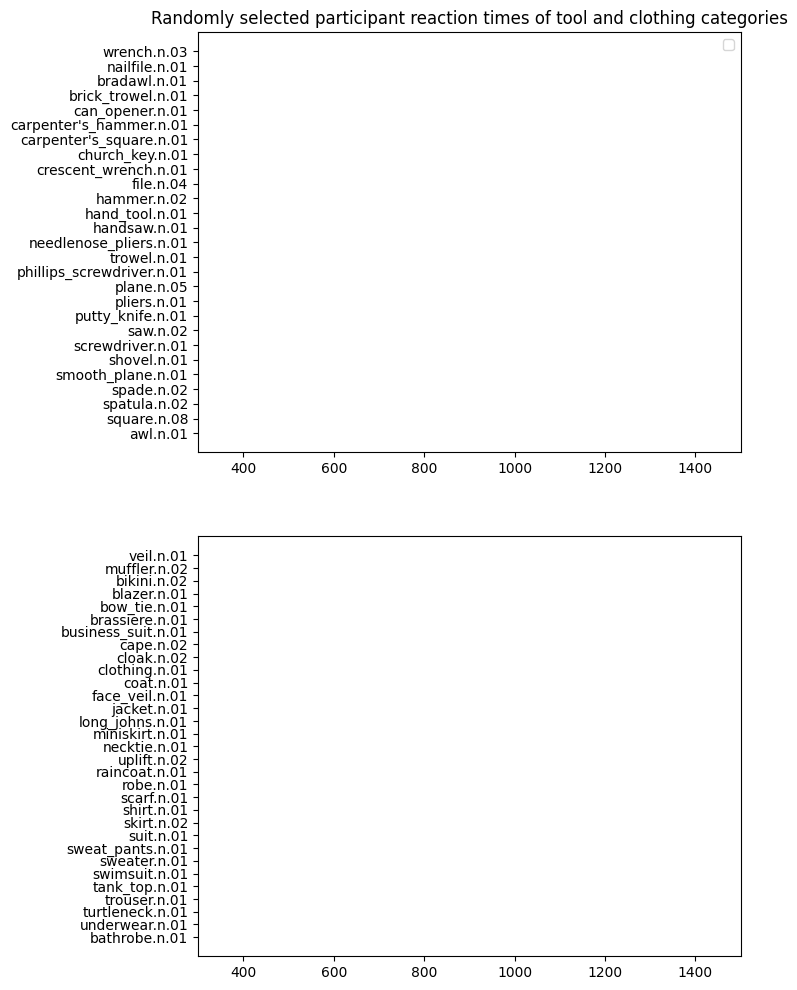

In [10]:
import matplotlib.pyplot as gg

data_tools = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["branch"]=="hand_tool.n.01"].sort_values(by=['sample_median_rt'])
data_cloth = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["branch"]=="clothing.n.01"].sort_values(by=['sample_median_rt'])

plot, (ax, ax2) = gg.subplots(nrows=2, figsize=(7, 12))

for p in range(1,len(participant_files)+1):
    ax.scatter(y=data_tools['synset'], x=data_tools[f'p{p}_rt'], s=5, c=data_tools["old_bl_label"])


ax.scatter(x=data_tools["sample_mean_rt"], y=data_tools["synset"], s=30, c="green")
ax.scatter(x=data_tools["sample_median_rt"], y=data_tools["synset"],  s=30, c="black")

for p in range(1,len(participant_files)+1):
    ax2.scatter(y=data_cloth['synset'], x=data_cloth[f'p{p}_rt'], s=5, c=data_cloth["old_bl_label"])


ax2.scatter(x=data_cloth["sample_mean_rt"], y=data_cloth["synset"], s=30, c="green")
ax2.scatter(x=data_cloth["sample_median_rt"], y=data_cloth["synset"],  s=30, c="black")


ax.set_title("Randomly selected participant reaction times of tool and clothing categories")
handles, labels = ax.get_legend_handles_labels()
handles, labels = ax2.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlim([300,1500])
ax2.set_xlim([300,1500])
gg.show()

Participant reaction time means are mostly slower than medians and are influenced by outliers.
No apparent clusters can be made out in this data. The value used to compute further ratings is the median.

In [11]:
import numpy as np

# need to sample 22 from full expert annotator agreement cases to balance the comparison
comp_data1 = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["expert_certainty"] == False]
comp_data2 = gold_standard_with_reaction_times.loc[gold_standard_with_reaction_times["expert_certainty"] == True].sample(22)
comp_data = comp_data1.append(comp_data2)

score_by_std_dev = [np.floor(x/100) for x in comp_data["sample_std_deviation"]]
ann_agree = [x*1 for x in comp_data["expert_certainty"]]
mean_accuracies = [np.floor(a*10)/10 for a in comp_data["sample_mean_acc"]]

pd.crosstab(ann_agree, [mean_accuracies], rownames=['Expert annotator agreement'], colnames=["Sample mean accuracy"])


C:\Users\ht409\AppData\Local\Temp\ipykernel_66904\2490047655.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_data = comp_data1.append(comp_data2)


Sample mean accuracy,-1.0
Expert annotator agreement,
0,22
1,22


## 2. Data Evaluation

Define depth-first recursive function to walk WordNet paths.
Generate annotation scores.


In [9]:
# The algorithm fails for now when one level in hierarchy is skipped, such as with clothes.
def list_tally(list):
    tally = dict()
    for l in list:
        if l in tally:
            tally[l]+=1
        else:
            tally[l]=1
    return tally



def cat_rater(data, category, hypers, dep=0):
    # Defining this category's rt, the list of hyponyms to return,
    # the current depth in the hierarchy and the list of hypernyms that have been traversed already.
    this = {"name":category[:-5], "rt":0}
    i=-1
    hyponyms = []
    depth = dep+1
    hypernyms = hypers
    if category in data["synset"].tolist():
        #If the category is in the data set, we get its reaction time
        i = data.loc[data["synset"]==category].index.tolist()[0]
        acc = data.at[i,'sample_mean_acc']
        this["rt"] = data.loc[data["synset"]==category]["sample_median_rt"].tolist()[0]


    # all hyponyms are queried from wordnet
    hypos = [hypo.name() for hypo in wn.synset(category).hyponyms()]

    # then, for all direct hyponyms, this function is called once,
    # returning all hypernym data ()
    for hy in hypos:
        hyper_f = hypernyms + [this]
        hs, depth, dat = cat_rater(data, hy, hyper_f, dep+1)
        hyponyms = hyponyms + hs

    # If this category is in the data set, it is compared to all hypernyms and hyponyms
    if(this['rt']>0):
        comp = []
        if len(hyponyms) >0:
            for h in hyponyms:
                if h["rt"] > 0:
                    val = h['rt'] > this['rt']
                    comp = comp + [val]
        if len(hypernyms) >0:
            for h in hypernyms:
                if h["rt"] > 0:
                    val = h['rt'] > this['rt']
                    comp = comp + [val]

        talley = list_tally(comp)

        if True in comp:
            v = talley[True]/len(comp)
            data.at[i,'blness']=v
            #print(f"{this} was faster than {talley[True]} other in path from {hypernyms}, to {hyponyms}")
        #if False in comp:
            #print(f"{this} was slower than {talley[False]} other in path from {hypernyms}, to {hyponyms}")
        #print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        hyponyms = hyponyms + [this]

    return hyponyms, depth, data

results = []

for b in branches:
    hypos, depth, rated_data = cat_rater(gold_standard_with_reaction_times, b, list())
    results.append((rts, hypos, depth))

rated_data.drop(rated_data.tail(1).index,inplace=True)

print(rated_data.loc[:,["synset", "sample_median_rt","old_bl_label", "blness"]].head(40).sort_values(by=["sample_median_rt"]))


                      synset  sample_median_rt  old_bl_label    blness
130              bikini.n.02        450.000000             0  1.000000
118       business_suit.n.01        487.250000             0  1.000000
77             clarinet.n.01        500.250000             1  1.000000
31                apple.n.01        510.250000             1  1.000000
68      acoustic_guitar.n.01        520.500000             0  0.500000
134                cape.n.02        523.750000             0  1.000000
120              blazer.n.01        532.250000             0  0.666667
95                chair.n.01        536.250000             1  1.000000
105            baby_bed.n.01        538.750000             1  1.000000
96             armchair.n.01        542.500000             0  0.500000
91                  bed.n.01        551.750000             1  1.000000
10   carpenter's_hammer.n.01        554.500000             0  0.500000
92             bunk_bed.n.01        557.500000             0  0.500000
133   

In [2]:
from sklearn import metrics

rated_data["blness_round"] = [np.floor(val) for val in rated_data["blness"]]

c_matrix = pd.crosstab(rated_data["old_bl_label"],rated_data["blness_round"])
#c_matrix = pd.crosstab(rated_data["old_bl_label"],[rated_data["expert_certainty"],rated_data["blness_round"]])
print(c_matrix)

NameError: name 'rated_data' is not defined

In [27]:
n_disagree = 0
blness_in_disagreement = 0

for i, row in rated_data.iterrows():
    expert_annot = row["old_bl_label"]
    expert_agr = row["expert_certainty"]
    crowd_annot = row["blness"]
    crowd_annot_r = np.floor(crowd_annot)
    synset = row["synset"]

    if expert_annot != crowd_annot_r:
        blness_in_disagreement += crowd_annot
        n_disagree += 1
        if expert_annot == 1:
            None
            #print(f"Experts thought {synset[:-5]} was basic level. Blness score: {crowd_annot}")
        if expert_annot == 0:
            print(f"Crowd thought {synset[:-5]} was basic level. \nExpert Annotator have full agreement: {expert_agr}\n")

print(f"The mean blness in disagreement is {blness_in_disagreement/n_disagree}")

Crowd thought bikini was basic level. 
Expert Annotator have full agreement: True

Crowd thought business_suit was basic level. 
Expert Annotator have full agreement: True

Crowd thought cape was basic level. 
Expert Annotator have full agreement: False

Crowd thought face_veil was basic level. 
Expert Annotator have full agreement: False

Crowd thought miniskirt was basic level. 
Expert Annotator have full agreement: True

Crowd thought raincoat was basic level. 
Expert Annotator have full agreement: True

Crowd thought spade was basic level. 
Expert Annotator have full agreement: True

Crowd thought sweat_pants was basic level. 
Expert Annotator have full agreement: True

Crowd thought watermelon was basic level. 
Expert Annotator have full agreement: True

The mean blness in disagreement is 0.6158730158730159


In [ ]:
def branch_grapher(synset, data, annot_group="crowd"):
    """Starting from <synset>, draws tree-like graph of WordNet, 
    showing the score received by given annotator group."""
    return False

## Simple majority agreement evaluation

In [131]:
# We first only want the results without a training round
exp_results = all_results.loc[all_results['final']==1]
gold_standard = gold_standard_blank.copy()

# Fill Gold Standard with columns of NA values per participant that later hold label
empty_label = [-1 for i in gold_standard.index]
gold_standard["majority_label"] = empty_label
for p in participants:
    gold_standard[f"p{p}_label"] = empty_label
# Add column for final majority label

# List of all participants
participants = exp_results['p_id'].unique()

for i, triple in experiment_project.iterrows():
    # Select triple items 
    sup = triple['hypernym']
    bl = triple['bl']
    sub = triple['hyponym']
    # Need to reformat names to fit the experiment results
    sup_f = sup.replace('.','_').replace("'", "").replace("-", "")
    bl_f = bl.replace('.','_').replace("'", "").replace("-", "")
    sub_f = sub.replace('.','_').replace("'", "").replace("-", "")
    # Find associated rows in dataset to be rated
    sup_index = gold_standard.index[gold_standard['synset']==sup].tolist()[0]
    bl_index = gold_standard.index[gold_standard['synset']==bl].tolist()[0]
    sub_index = gold_standard.index[gold_standard['synset']==sub].tolist()[0]

    # Get the reaction times per item for each participant
    sup_rts = exp_results.loc[(exp_results['c_name']==sup_f) & (exp_results['img']==sub_f)][['c_name', 'stim_type','p_id', 'react_time','accurate']]
    bl_rts = exp_results.loc[exp_results['c_name']==bl_f][['c_name','stim_type','p_id', 'react_time','accurate']]
    sub_rts = exp_results.loc[exp_results['c_name']==sub_f][['c_name','stim_type','p_id', 'react_time','accurate']]

    # Per participant, find reaction times for triple items
    for p in participants:
        sup_dat = sup_rts.loc[(sup_rts['p_id']==p)&(sup_rts['accurate']==1)]
        bl_dat = bl_rts.loc[(bl_rts['p_id']==p)&(bl_rts['accurate']==1)]
        sub_dat = sub_rts.loc[(sub_rts['p_id']==p)&(sub_rts['accurate']==1)]
        gold_standard.at[sup_index, f"p{p}_label"] = 0
        all_dat = pd.concat([sup_dat,bl_dat,sub_dat])

        if (len(sup_dat.index)>0) & (len(bl_dat.index)>0) & (len(sub_dat.index)>0):
            fastest = all_dat.loc[all_dat['react_time']==all_dat['react_time'].min()]
            fastest_c = fastest["c_name"].tolist()[0]
            #print(fastest)
            #enter annotation in data frame
            if fastest_c == bl_f:
                gold_standard.at[bl_index, f"p{p}_label"] = 1
                gold_standard.at[sub_index, f"p{p}_label"] = 0
            if fastest_c == sub_f:
                gold_standard.at[bl_index, f"p{p}_label"] = 0
                gold_standard.at[sub_index, f"p{p}_label"] = 1
            if fastest_c == sup_f:
                gold_standard.at[bl_index, f"p{p}_label"] = 0
                gold_standard.at[sub_index, f"p{p}_label"] = 0


        else:
            None
        
lab_cols = [f"p{p}_label" for p in participants]
mode = gold_standard[lab_cols].mode(axis=1)
gold_standard['majority_label'] = np.where(mode.isna().any(1), mode[0], 'split')

In [142]:
from sklearn.metrics import cohen_kappa_score
import statsmodels.stats.inter_rater as rater 
from sklearn import metrics

c_matrix = pd.crosstab(gold_standard["expert_label"],gold_standard["majority_label"])
#c_matrix = pd.crosstab(rated_data["old_bl_label"],[rated_data["expert_certainty"],rated_data["blness_round"]])
print(c_matrix)

#votes = [gold_standard[p].tolist() for p in lab_cols]

#agg = rater.aggregate_raters(votes)
#print(agg[0])

#rater.fleiss_kappa(agg[0])


majority_label  -1.0  0.0  1.0  split
expert_label                         
0                  1   47   15      8
1                  1   39   18      8
